In [8]:
!pip install d2l==0.14.
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 5.2 MB/s 
  Attempting uninstall: d2l
    Found existing installation: d2l 0.17.5
    Uninstalling d2l-0.17.5:
      Successfully uninstalled d2l-0.17.5


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

import torch
from torch import nn
from d2l import torch as d2l

In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

### 从零开始实现
从头开始实现权重衰减，只需将L2的平方惩罚添加到原始目标函数中

1. 初始化模型参数

首先定义一个函数来随机初始化模型参数

In [5]:
def init_params():
  w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
  b = torch.zeros(1, requires_grad=True)
  return [w, b]

2. 定义L2范数惩罚

实现这一惩罚最方便的方法是对所有项求平方后并将它们求和

In [9]:
def l2_penalty(w):
  return torch.sum(w.pow(2)) / 2

3. 定义训练代码实现

下面的代码将模型拟合训练数据集，并在测试数据集上进行评估。 从 3节以来，线性网络和平方损失没有变化， 所以我们通过d2l.linreg和d2l.squared_loss导入它们。 唯一的变化是损失现在包括了惩罚项。

In [12]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

w的L2范数是： 13.093466758728027


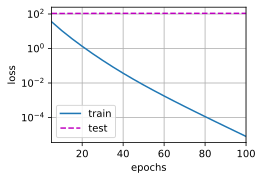

In [13]:
train(lambd=0)

w的L2范数是： 0.4097701907157898


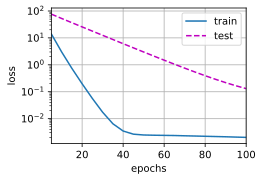

In [18]:
train(lambd=3)

4. 简洁实现

由于权重衰减在神经网络优化中很常用， 深度学习框架为了便于我们使用权重衰减， 将权重衰减集成到优化算法中，以便与任何损失函数结合使用。 此外，这种集成还有计算上的好处， 允许在不增加任何额外的计算开销的情况下向算法中添加权重衰减。 由于更新的权重衰减部分仅依赖于每个参数的当前值， 因此优化器必须至少接触每个参数一次。

In [19]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

这些图看起来和我们从零开始实现权重衰减时的图相同。 然而，它们运行得更快，更容易实现。 对于更复杂的问题，这一好处将变得更加明显。

w的L2范数： 0.3338663876056671


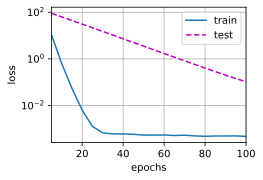

In [20]:
train_concise(3)

5. 小结

正则化是处理过拟合的常用方法：在训练集的损失函数中加入惩罚项，以降低学习到的模型的复杂度。

保持模型简单的一个特别的选择是使用惩罚的权重衰减。这会导致学习算法更新步骤中的权重衰减。

权重衰减功能在深度学习框架的优化器中提供。

在同一训练代码实现中，不同的参数集可以有不同的更新行为。